<a href="https://colab.research.google.com/github/TamiHime/PyBamm_FastCycling/blob/main/PyBamm_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyBaMM and required dependencies
!pip install -q git+https://github.com/pybamm-team/PyBaMM.git@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pybamm
import json
import numpy as np
import matplotlib.pyplot as plt

PyBaMM can collect usage data and send it to the PyBaMM team to help us improve the software.
We do not collect any sensitive information such as models, parameters, or simulation results - only information on which parts of the code are being used and how frequently.
This is entirely optional and does not impact the functionality of PyBaMM.
For more information, see https://docs.pybamm.org/en/latest/source/user_guide/index.html#telemetry

Timeout reached. Defaulting to not enabling telemetry.
Do you want to enable telemetry? (Y/n): Y


In [15]:
model = pybamm.lithium_ion.DFN(
    {
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
    }
)

# Chen2020 commercial cell parameters
param = pybamm.ParameterValues("OKane2022")

cycle_number = 10

C_rate = [0.1, 0.5, 1, 3, 5]
color = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
results = {}

# Stable protocol: 1C discharge, C/3 charge, 15-minute CV hold
cycle_number = 10

for rate in C_rate:
    print(f"Running simulation for {rate}C charge rate")

    exp = pybamm.Experiment(
        [
            "Hold at 4.2 V until C/100 (5 minute period)",
            "Rest for 4 hours (5 minute period)",
            "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
            "Charge at 0.3C until 4.2 V (5 minute period)",
            "Hold at 4.2 V until C/100 (5 minute period)",
        ]
        + [
            (
                "Discharge at 1C until 2.5 V (1 minute period)",
                f"Charge at {rate}C until 4.2 V (5 minute period)",
                "Hold at 4.2 V until C/100 (5 minute period)",
            )
        ]
        * cycle_number
        + ["Discharge at 0.1C until 2.5 V (5 minute period)"]
    )

    solver = pybamm.IDAKLUSolver()
    sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, solver=solver)
    sol = sim.solve()

    # Extract degradation metrics
    Qt = sol["Throughput capacity [A.h]"].entries
    Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
    Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
    Q_plating = sol["Loss of capacity to positive lithium plating [A.h]"].entries

    # Store by charge rate
    results[f"{rate}C"] = {
        "Qt": Qt,
        "Q_SEI": Q_SEI,
        "Q_SEI_cr": Q_SEI_cr,
        "Q_plating": Q_plating,
    }

Running simulation for 0.1C charge rate
Running simulation for 0.5C charge rate
Running simulation for 1C charge rate
Running simulation for 3C charge rate
Running simulation for 5C charge rate


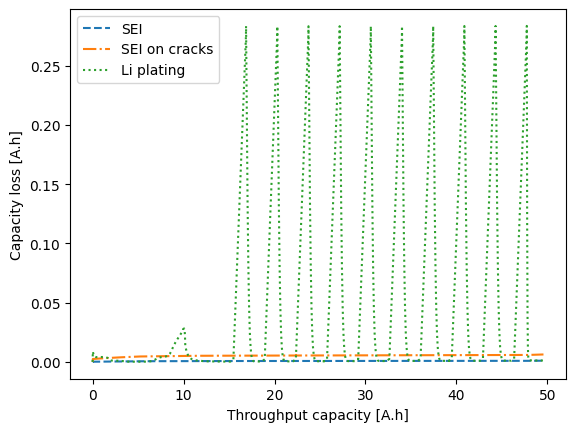

In [23]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h
plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

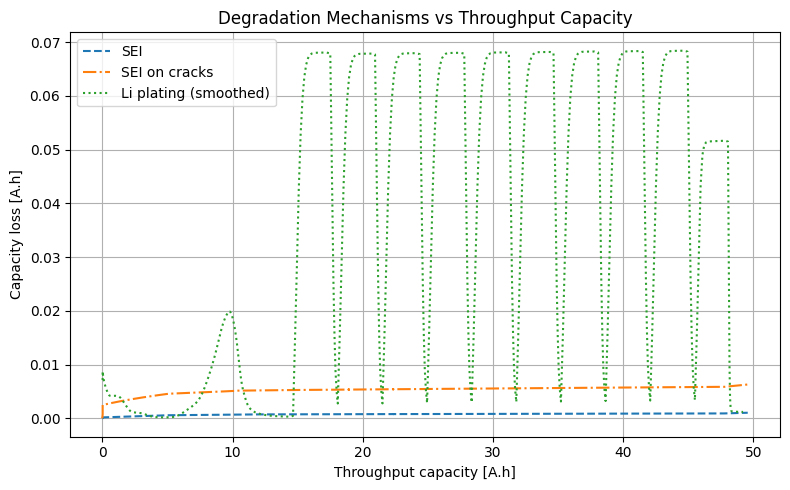

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Smoothing function
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Extract degradation mechanisms
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h

# Smooth only the Li plating data
Qt_avg = moving_average(Qt, window_size=20)
Q_plating_avg = moving_average(Q_plating, window_size=20)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt_avg, Q_plating_avg, label="Li plating (smoothed)", linestyle="dotted")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.title("Degradation Mechanisms vs Throughput Capacity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

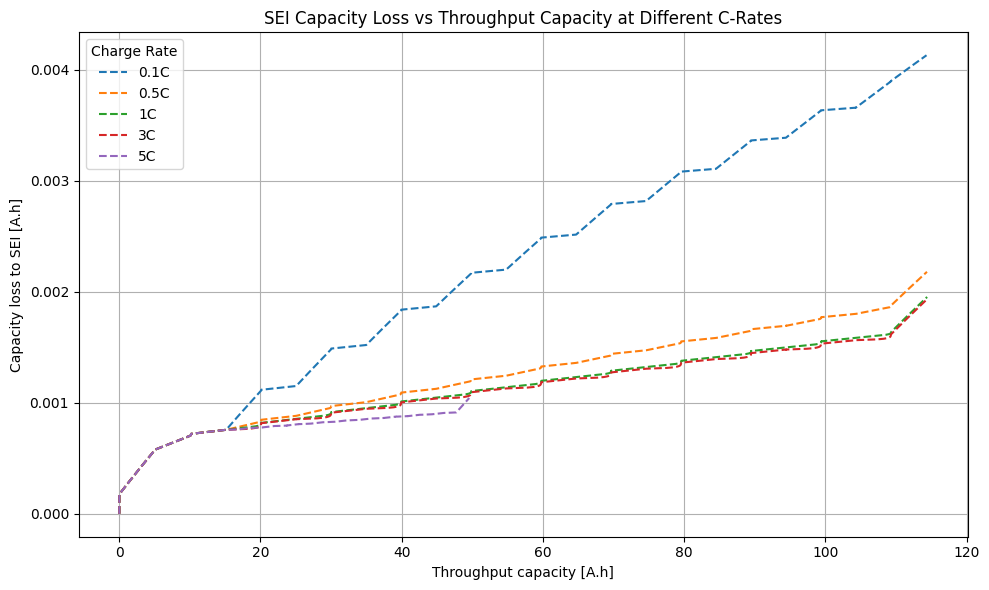

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Loop through each rate and plot SEI loss
for rate_label, data in results.items():
    Qt = data["Qt"]
    Q_SEI = data["Q_SEI"]
    plt.plot(Qt, Q_SEI, label=f"{rate_label}", linestyle="--")

plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss to SEI [A.h]")
plt.title("SEI Capacity Loss vs Throughput Capacity at Different C-Rates")
plt.legend(title="Charge Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

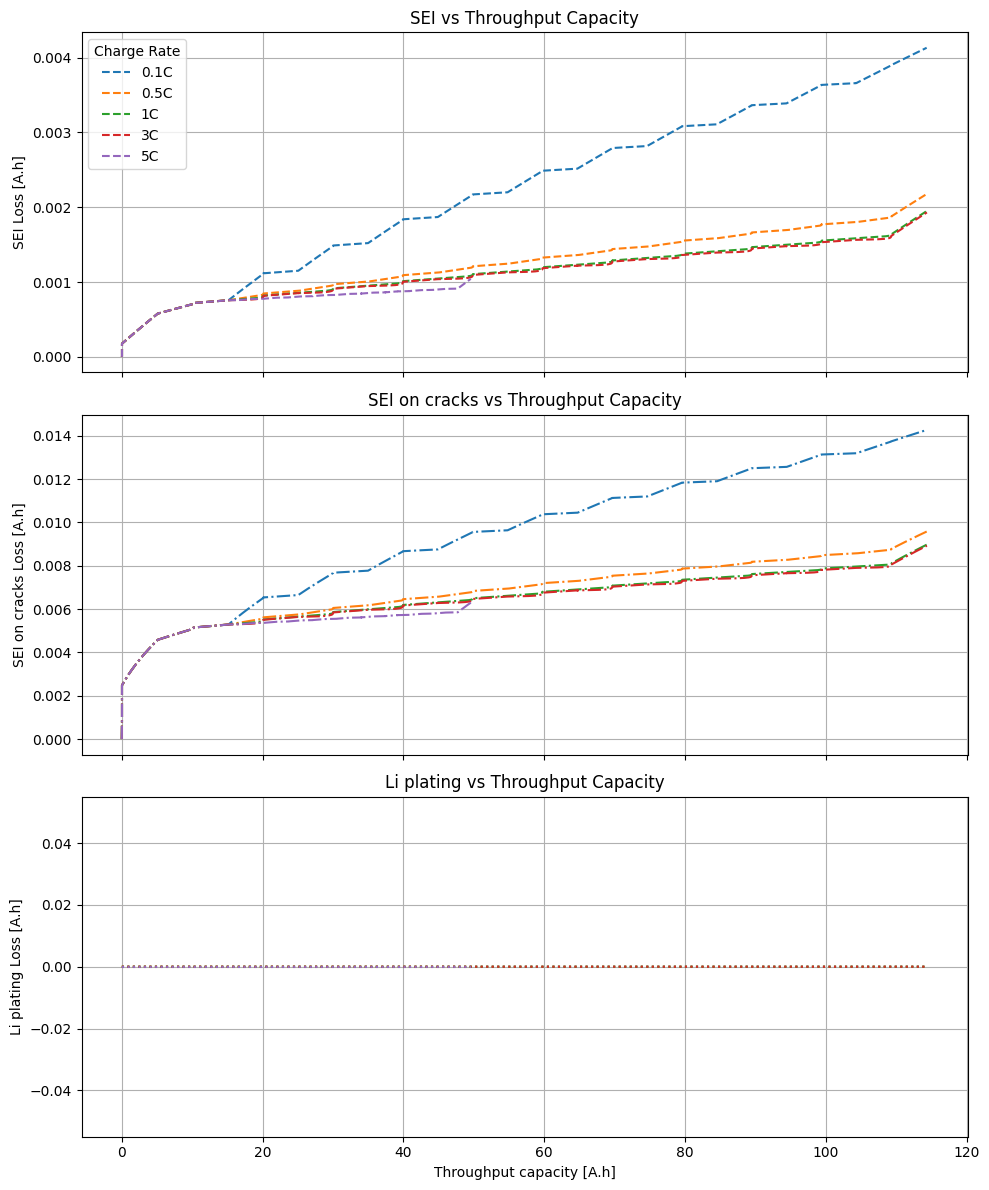

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Define mechanism labels and y-data keys
mechanisms = [
    ("SEI", "Q_SEI", "--"),
    ("SEI on cracks", "Q_SEI_cr", "-."),
    ("Li plating", "Q_plating", ":"),
]

for idx, (label, key, linestyle) in enumerate(mechanisms):
    ax = axs[idx]
    for rate_label, data in results.items():
        Qt = data["Qt"]
        y_data = data[key]
        ax.plot(Qt, y_data, label=rate_label, linestyle=linestyle)
    ax.set_ylabel(f"{label} Loss [A.h]")
    ax.set_title(f"{label} vs Throughput Capacity")
    ax.grid(True)
    if idx == 0:
        ax.legend(title="Charge Rate")

axs[-1].set_xlabel("Throughput capacity [A.h]")
plt.tight_layout()
plt.show()


In [22]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop through each C-rate result
for rate_label, data in results.items():
    Qt = data["Qt"]
    LAM_neg = data["LAM_neg"]
    LAM_pos = data["LAM_pos"]

    # Plot negative electrode
    plt.plot(Qt, LAM_neg, label=f"{rate_label} - LAM neg", linestyle="--")

    # Plot positive electrode
    plt.plot(Qt, LAM_pos, label=f"{rate_label} - LAM pos", linestyle="-")

# Label the axes
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Loss of active material [%]")
plt.title("Loss of Active Material vs Throughput Capacity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'LAM_neg'

<Figure size 1000x600 with 0 Axes>